In [177]:
import gym
from gym import spaces
import copy
import math
import random
import time
import numpy as np
from random import sample
from dataclasses import dataclass
from collections import namedtuple
from itertools import count
from IPython import display
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import matplotlib.pyplot as plt

import logging

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


In [178]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    logging.info(f'Running on {torch.cuda.get_device_name(0)}')
else:
    device = torch.device('cpu')

In [278]:
class MyEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    actions = {
        "idle" : 0,
        "left" : 1,
        "right" : 2,
        "up" : 3,
        "down" : 4
    }

    def __init__(self, size, num_obstacles, num_enemies):        
        super(MyEnv, self).__init__()
        self.size = size
        self.num_obstacles = num_obstacles
        self.num_enemies = num_enemies

        self.action_space = spaces.Discrete(5)
        self.passable = 0
        self.obstacle = 1        
        self.enemy = 3
        self.exit = 4
        self.agent = 5        

        self.grid = None        

    def reset(self):
        #generates grid
        self.grid = np.ones((self.size+2, self.size+2))
        self.grid[1:-1, 1:-1] = self.passable
        #generates obstacles
        for i in range(self.num_obstacles):
            self.grid[random.randint(1,self.size)][random.randint(1,self.size)] = self.obstacle
        #generates enemies
        for i in range(self.num_enemies):
            self.grid[random.randint(1,self.size)][random.randint(1,self.size)] = self.enemy
        #generates exit
        self.grid[random.randint(1,self.size)][random.randint(1,self.size)] = self.exit
        #generates agent position
        self.grid[random.randint(1,self.size)][random.randint(1,self.size)] = self.agent

        return self.grid

    def step(self, action):
        reward = 0.01
        done = False

        agent_position = np.where(self.grid == self.agent)
        agent_position = agent_position[0][0], agent_position[1][0]

        agent_position_new = agent_position        

        if action == self.actions["idle"]:
            reward -= 0.01
            pass
        elif action == self.actions["left"]:
            agent_position_new = agent_position[0], agent_position[1]-1
        elif action == self.actions["right"]:
            agent_position_new = agent_position[0], agent_position[1]+1           
        elif action == self.actions["up"]:
            agent_position_new = agent_position[0]-1, agent_position[1]            
        elif action == self.actions["down"]:
            agent_position_new = agent_position[0]+1, agent_position[1]
        

        if self.grid[agent_position_new] == self.obstacle:
            reward -= 0.01
            agent_position_new = agent_position
        elif self.grid[agent_position_new] == self.passable:
            self.grid[agent_position] = self.passable
            self.grid[agent_position_new] = self.agent
        elif self.grid[agent_position_new] == self.enemy:            
            reward = 0
            done = True
        elif self.grid[agent_position_new] == self.exit:
            reward = 1000
            done = True

        return self.grid, reward, done, {}   

    def render(self, mode='human'):
        return self.grid


In [279]:
env = MyEnv(size=12, num_obstacles=16, num_enemies=2)

In [255]:
env.reset()

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 4., 1., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 5., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 3., 1.],
       [1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

Sample action: 3, up
Reward: -1, Done: False


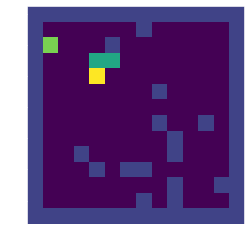

In [183]:
sample_action = env.action_space.sample()
grd, rwrd, dn, _ = env.step(sample_action)
plt.imshow(grd)
print(f"Sample action: {sample_action}, {list(env.actions.keys())[list(env.actions.values()).index(sample_action)]}")
print(f"Reward: {rwrd}, Done: {dn}")

In [280]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed):
        super(QNetwork,self).__init__()
        self.seed = torch.manual_seed(seed)
        self.flatten = nn.Flatten(start_dim=1)
        self.fc1= nn.Linear(state_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)         
        self.fc4 = nn.Linear(256,action_size)
        
    def forward(self,x):
        #print(x.size())
        # x = state
        x = self.flatten(x)
        #print(x.size())
        x = F.relu(self.fc1(x))
        #x = self.bn1(x)
        x = F.relu(self.fc2(x))
        #x = self.bn2(x)
        x = F.relu(self.fc3(x))
        #x = self.bn3(x)
        x = F.relu(self.fc4(x))
        
        return x

In [281]:
from collections import namedtuple, deque 

buffer_size = 100000
batch_size = 1024
gamma = 0.99
tau = 1e-5
learning_rate = 1e-3
update_rate = 10

class Agent():    
    def __init__(self, state_size, action_size, seed):       
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)        
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr = learning_rate)
        self.memory = ReplayBuffer(action_size, buffer_size, batch_size, seed)
        self.t_step = 0
        self.total_loss = []
        
    def step(self, state, action, reward, next_step, done):
        self.memory.add(state, action, reward, next_step, done)

        self.t_step = (self.t_step+1) % update_rate
        if self.t_step == 0:
            if len(self.memory) > batch_size:
                experience = self.memory.sample()                
                self.learn(experience, gamma)

    def act(self, state, eps = 0):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()
        
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
            
    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences        
        #criterion = torch.nn.SmoothL1Loss()
        criterion = torch.nn.MSELoss()
        self.qnetwork_local.train()
        self.qnetwork_target.eval()
               
        predicted_targets = self.qnetwork_local(states).gather(1,actions)
    
        with torch.no_grad():
            labels_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
       
        labels = rewards + (gamma*labels_next*(1-dones))
        
        loss = criterion(predicted_targets, labels).to(device)
        self.total_loss.append(loss.item())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.soft_update(self.qnetwork_local,self.qnetwork_target, tau)
            
    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(),
                                           local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1-tau)*target_param.data)
            
class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):        
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experiences = namedtuple("Experience", field_names=["state",
                                                               "action",
                                                               "reward",
                                                               "next_state",
                                                               "done"])
        self.seed = random.seed(seed)
        
    def add(self,state, action, reward, next_state,done):
        e = self.experiences(state, action, reward, next_state, done)
        self.memory.append(e)
        
    def sample(self):
        experiences = random.sample(self.memory,k=self.batch_size)
        
        states = torch.from_numpy(np.stack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.stack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)        
        return (states,actions,rewards,next_states,dones)

    def __len__(self):
        return len(self.memory)


In [282]:
agent = Agent(state_size=196, action_size=5, seed=55555)

def training_loop(n_episodes= 10000, max_t = 500, eps_start=0.99, eps_end = 0.01,
       eps_decay=0.99):
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)            
            state = next_state
            score += reward
            
            scores_window.append(score)
            scores.append(score)
            if done:
                break            
            
        eps = max(eps*eps_decay, eps_end)
        print(f"\rEpisode {i_episode}\tEpisode Score {score}\tLast iters score {np.mean(scores_window)}", end="")        
        if i_episode % 100==0:
            print(f"\rEpisode {i_episode}\tAverage Score {np.mean(scores)}\nAverage loss: {np.mean(agent.total_loss)}")
            print(f"Random action sample probability: {eps}\n")
            agent.total_loss = []
            
        if np.mean(scores_window)>=5000.0:
            print(f"\nEnvironment solved in {i_episode-100} epsiodes.\tAverage score: {np.mean(scores_window)}")
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break        

    return scores

In [277]:
scores = training_loop()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)),scores)
plt.ylabel('Score')
plt.xlabel('Epsiode #')
plt.show()

Episode 100	Average Score 201.75929776448137
Average loss: 1173.8345339077835
Random action sample probability: 0.36237201786049694

Episode 200	Average Score 213.5390398872304
Average loss: 720.2995909207239
Random action sample probability: 0.13263987810938213

Episode 225	Episode Score 495.2900000000029	Last iters score 446.2661000000024

KeyboardInterrupt: 

In [272]:

agent = Agent(state_size=196,action_size=5,seed=555)
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

for i in range(3):
    state = env.reset()
    img = plt.imshow(env.render(mode='rgb_array'))
    for j in range(200):
        sleep(0.2)
        action = agent.act(state)
        img.set_data(env.render(mode='rbg_array'))
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        state,reward,done,_ = env.step(action)
        if done:
            break

env.close()

KeyboardInterrupt: 